In [8]:
# Blackjack Machine Learning Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [9]:
# Check file size and load data efficiently
import os
file_path = 'blackjack_simulator.csv'
file_size = os.path.getsize(file_path) / (1024*1024)  # Size in MB
print(f"File size: {file_size:.1f} MB")

# Load a sample of the data for faster processing
print("Loading data sample...")
df = pd.read_csv(file_path, nrows=500000)  # Load first 500k rows
print(f"Loaded {len(df)} rows")
print(f"Columns: {list(df.columns)}")
df.head()


File size: 3714.1 MB
Loading data sample...
Loaded 500000 rows
Columns: ['shoe_id', 'cards_remaining', 'dealer_up', 'initial_hand', 'dealer_final', 'dealer_final_value', 'player_final', 'player_final_value', 'actions_taken', 'run_count', 'true_count', 'win']


,shoe_id,cards_remaining,dealer_up,initial_hand,dealer_final,dealer_final_value,player_final,player_final_value,actions_taken,run_count,true_count,win
0,0,416,10,"[10, 11]","[10, 4, 10]",24,"[[10, 11]]",['BJ'],[['S']],1,0,1.5
1,0,411,10,"[5, 5]","[10, 8]",18,"[[5, 5, 11]]",[21],"[['H', 'S']]",-2,0,1.0
2,0,406,6,"[3, 10]","[6, 6, 10]",22,"[[3, 10]]",[13],[['S']],-2,0,1.0
3,0,401,10,"[5, 9]","[10, 8]",18,"[[5, 9, 11, 3]]",[18],"[['H', 'H', 'S']]",-1,0,0.0
4,0,395,8,"[6, 10]","[8, 2, 10]",20,"[[6, 10, 10]]",[26],[['H']],-1,0,-1.0


In [10]:
# Parse the string representations of lists
import ast

def parse_hand(hand_str):
    """Parse hand string like '[10, 11]' into list of integers"""
    try:
        return ast.literal_eval(hand_str)
    except:
        return []

def parse_actions(actions_str):
    """Parse actions string like "[['H', 'S']]" into list of action lists"""
    try:
        return ast.literal_eval(actions_str)
    except:
        return []

# Parse the data
df['player_hand'] = df['initial_hand'].apply(parse_hand)
df['dealer_hand'] = df['dealer_final'].apply(parse_hand)
df['actions'] = df['actions_taken'].apply(parse_actions)

print("Sample parsed data:")
print(df[['player_hand', 'dealer_hand', 'actions', 'win']].head())


Sample parsed data:
  player_hand  dealer_hand      actions  win
0    [10, 11]  [10, 4, 10]        [[S]]  1.5
1      [5, 5]      [10, 8]     [[H, S]]  1.0
2     [3, 10]   [6, 6, 10]        [[S]]  1.0
3      [5, 9]      [10, 8]  [[H, H, S]]  0.0
4     [6, 10]   [8, 2, 10]        [[H]] -1.0


In [11]:
# Feature Engineering
def calculate_hand_value(hand):
    """Calculate hand value with proper Ace handling"""
    if not hand:
        return 0
    
    total = sum(hand)
    aces = hand.count(11)  # Assuming 11 represents Ace
    
    # Adjust for Aces
    while total > 21 and aces > 0:
        total -= 10
        aces -= 1
    
    return total

def is_soft_hand(hand):
    """Check if hand is soft (contains Ace counted as 11)"""
    if not hand:
        return False
    return 11 in hand and sum(hand) <= 21

def is_pair(hand):
    """Check if initial hand is a pair"""
    if len(hand) != 2:
        return False
    return hand[0] == hand[1]

def can_split(hand):
    """Check if hand can be split (pair of same value)"""
    return is_pair(hand)

def can_double(hand):
    """Check if hand can be doubled (exactly 2 cards)"""
    return len(hand) == 2

# Create features
df['player_total'] = df['player_hand'].apply(calculate_hand_value)
df['is_soft'] = df['player_hand'].apply(is_soft_hand)
df['is_pair'] = df['player_hand'].apply(is_pair)
df['can_split'] = df['player_hand'].apply(can_split)
df['can_double'] = df['player_hand'].apply(can_double)

# Dealer upcard (already in the data)
df['dealer_upcard'] = df['dealer_up']

print("Feature engineering complete!")
print(f"Player total range: {df['player_total'].min()} - {df['player_total'].max()}")
print(f"Dealer upcard range: {df['dealer_upcard'].min()} - {df['dealer_upcard'].max()}")
print(f"Soft hands: {df['is_soft'].sum()}")
print(f"Pairs: {df['is_pair'].sum()}")


Feature engineering complete!
Player total range: 4 - 21
Dealer upcard range: 2 - 11
Soft hands: 71831
Pairs: 73150


In [12]:
# Create target variable: optimal action based on win rate
def get_optimal_action(row):
    """Determine optimal action based on win rate for each action type"""
    actions = row['actions']
    win = row['win']
    
    if not actions or not actions[0]:
        return 'S'  # Default to Stand if no actions
    
    # For now, use the first action taken as the target
    # In a more sophisticated approach, we'd analyze win rates for each possible action
    return actions[0][0] if actions[0] else 'S'

df['optimal_action'] = df.apply(get_optimal_action, axis=1)

# Prepare features for ML
feature_columns = ['player_total', 'is_soft', 'is_pair', 'can_split', 'can_double', 'dealer_upcard']
X = df[feature_columns].copy()
y = df['optimal_action'].copy()

# Convert boolean columns to int
X['is_soft'] = X['is_soft'].astype(int)
X['is_pair'] = X['is_pair'].astype(int)
X['can_split'] = X['can_split'].astype(int)
X['can_double'] = X['can_double'].astype(int)

# Encode categorical target variable to numeric for XGBoost
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Target variable distribution:")
print(y.value_counts())
print(f"\nEncoded classes: {le.classes_}")
print(f"Encoded values: {y_encoded}")
print(f"\nFeatures shape: {X.shape}")
print(f"Features: {feature_columns}")


Target variable distribution:
optimal_action
S    221183
H    158857
D     48938
N     38133
R     20623
P     12266
Name: count, dtype: int64

Encoded classes: ['D' 'H' 'N' 'P' 'R' 'S']
Encoded values: [5 1 5 ... 0 5 1]

Features shape: (500000, 6)
Features: ['player_total', 'is_soft', 'is_pair', 'can_split', 'can_double', 'dealer_upcard']


In [13]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='mlogloss'),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42, max_iter=500)
}

# Train and evaluate classification models
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'predictions': y_pred
    }
    print(f"{name} Accuracy: {accuracy:.4f}")

# Display results
print("\nModel Performance Summary:")
for name, result in results.items():
    print(f"{name}: {result['accuracy']:.4f}")


Training set size: 400000
Test set size: 100000

Training Logistic Regression...
Logistic Regression Accuracy: 0.7494

Training Random Forest...
Random Forest Accuracy: 0.9806

Training XGBoost...
XGBoost Accuracy: 0.9806

Training Neural Network...
Neural Network Accuracy: 0.9806

Model Performance Summary:
Logistic Regression: 0.7494
Random Forest: 0.9806
XGBoost: 0.9806
Neural Network: 0.9806


In [14]:
# Win Probability Regression Models
print("Training Win Probability Models...")

# Create regression target (win values)
y_reg = df['win'].copy()
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

regression_models = {
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost Regressor': xgb.XGBRegressor(random_state=42),
    'Neural Network Regressor': MLPRegressor(hidden_layer_sizes=(100, 50), random_state=42, max_iter=500)
}

regression_results = {}

for name, model in regression_models.items():
    print(f"Training {name}...")
    model.fit(X_train_reg, y_train_reg)
    y_pred_reg = model.predict(X_test_reg)
    
    mse = mean_squared_error(y_test_reg, y_pred_reg)
    mae = mean_absolute_error(y_test_reg, y_pred_reg)
    r2 = r2_score(y_test_reg, y_pred_reg)
    
    regression_results[name] = {
        'model': model,
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'predictions': y_pred_reg
    }
    
    print(f"{name} - MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

print("\nRegression Model Performance Summary:")
for name, result in regression_results.items():
    print(f"{name} - R²: {result['r2']:.4f}")


Training Win Probability Models...
Training Random Forest Regressor...
Random Forest Regressor - MSE: 1.0799, MAE: 0.8569, R²: 0.1789
Training XGBoost Regressor...
XGBoost Regressor - MSE: 1.0799, MAE: 0.8569, R²: 0.1789
Training Neural Network Regressor...
Neural Network Regressor - MSE: 1.0801, MAE: 0.8582, R²: 0.1787

Regression Model Performance Summary:
Random Forest Regressor - R²: 0.1789
XGBoost Regressor - R²: 0.1789
Neural Network Regressor - R²: 0.1787


In [15]:
# Ensemble Models
print("Creating Ensemble Models...")

# Get the best performing models
best_classifier = max(results.items(), key=lambda x: x[1]['accuracy'])
print(f"Best Classifier: {best_classifier[0]} with accuracy {best_classifier[1]['accuracy']:.4f}")

# Create voting classifier with top 3 models
top_models = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)[:3]
voting_models = [(name, result['model']) for name, result in top_models]

voting_clf = VotingClassifier(estimators=voting_models, voting='soft')
voting_clf.fit(X_train, y_train)
voting_pred = voting_clf.predict(X_test)
voting_accuracy = accuracy_score(y_test, voting_pred)

print(f"Voting Classifier Accuracy: {voting_accuracy:.4f}")

# Add to results
results['Voting Ensemble'] = {
    'model': voting_clf,
    'accuracy': voting_accuracy,
    'predictions': voting_pred
}


Creating Ensemble Models...
Best Classifier: Random Forest with accuracy 0.9806
Voting Classifier Accuracy: 0.9806


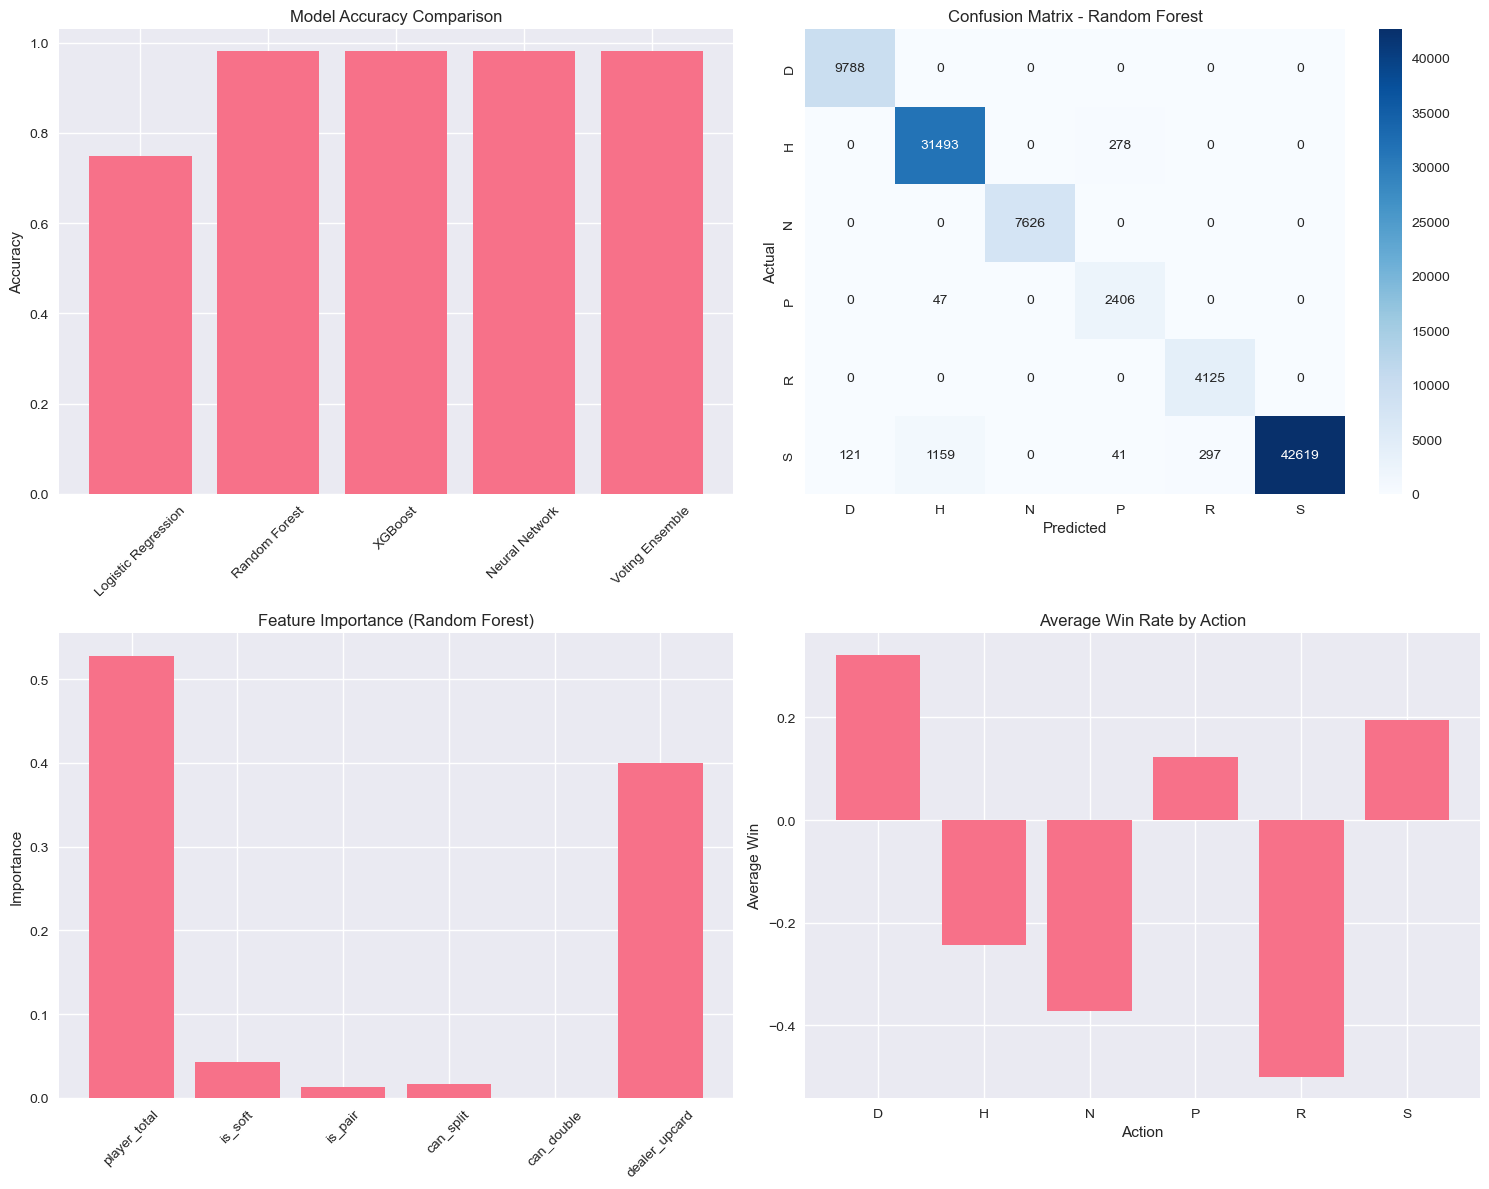

In [16]:
# Visualizations and Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Model Accuracy Comparison
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]
axes[0, 0].bar(model_names, accuracies)
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Confusion Matrix for Best Model
best_model_name = best_classifier[0]
best_predictions = results[best_model_name]['predictions']
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[0, 1], cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[0, 1].set_title(f'Confusion Matrix - {best_model_name}')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')

# 3. Feature Importance (Random Forest)
rf_model = results['Random Forest']['model']
feature_importance = rf_model.feature_importances_
axes[1, 0].bar(feature_columns, feature_importance)
axes[1, 0].set_title('Feature Importance (Random Forest)')
axes[1, 0].set_ylabel('Importance')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Win Rate by Action
action_win_rates = df.groupby('optimal_action')['win'].mean()
axes[1, 1].bar(action_win_rates.index, action_win_rates.values)
axes[1, 1].set_title('Average Win Rate by Action')
axes[1, 1].set_ylabel('Average Win')
axes[1, 1].set_xlabel('Action')

plt.tight_layout()
plt.show()


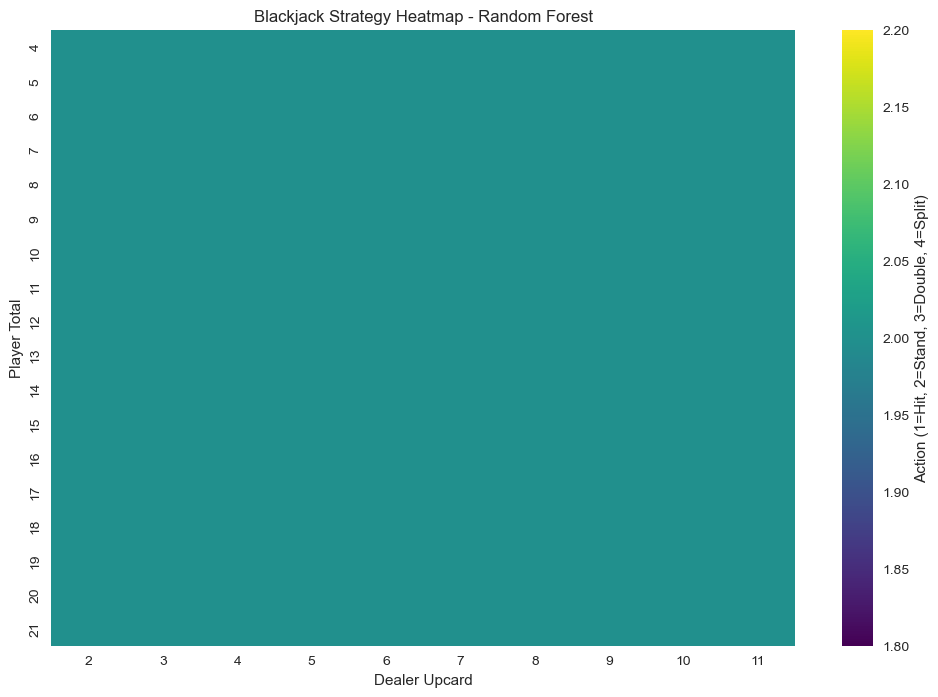

In [17]:
# Strategy Heatmap
def create_strategy_heatmap(model, feature_columns):
    """Create a heatmap showing model recommendations"""
    # Create all possible combinations
    player_totals = range(4, 22)
    dealer_upcards = range(2, 12)
    
    strategy_matrix = np.zeros((len(player_totals), len(dealer_upcards)))
    
    for i, player_total in enumerate(player_totals):
        for j, dealer_upcard in enumerate(dealer_upcards):
            # Create feature vector
            features = np.array([[
                player_total,
                0,  # is_soft
                0,  # is_pair
                0,  # can_split
                1,  # can_double
                dealer_upcard
            ]])
            
            # Get prediction
            prediction = model.predict(features)[0]
            
            # Convert to numeric for heatmap
            action_map = {'H': 1, 'S': 2, 'D': 3, 'P': 4}
            strategy_matrix[i, j] = action_map.get(prediction, 2)
    
    return strategy_matrix, player_totals, dealer_upcards

# Create strategy heatmap for best model
strategy_matrix, player_totals, dealer_upcards = create_strategy_heatmap(
    results[best_model_name]['model'], feature_columns
)

plt.figure(figsize=(12, 8))
sns.heatmap(strategy_matrix, 
            xticklabels=dealer_upcards, 
            yticklabels=player_totals,
            cmap='viridis',
            cbar_kws={'label': 'Action (1=Hit, 2=Stand, 3=Double, 4=Split)'})
plt.title(f'Blackjack Strategy Heatmap - {best_model_name}')
plt.xlabel('Dealer Upcard')
plt.ylabel('Player Total')
plt.show()


In [19]:
# Model Evaluation Summary
print("BLACKJACK MACHINE LEARNING ANALYSIS SUMMARY")

print(f"\nDataset Information:")
print(f"- Total samples analyzed: {len(df):,}")
print(f"- Features used: {', '.join(feature_columns)}")
print(f"- Target variable: Optimal action (H/S/D/P)")

print(f"\nClassification Model Results:")
for name, result in results.items():
    print(f"- {name}: {result['accuracy']:.4f} accuracy")

print(f"\nRegression Model Results:")
for name, result in regression_results.items():
    print(f"- {name}: R² = {result['r2']:.4f}")

print(f"\nBest Performing Model: {best_model_name}")
print(f"Accuracy: {results[best_model_name]['accuracy']:.4f}")

print(f"\nAction Distribution in Data:")
print(y.value_counts())
print(f"\nEncoded Action Mapping:")
for i, action in enumerate(le.classes_):
    print(f"  {i}: {action}")

print(f"\nFeature Importance (Random Forest):")
rf_importance = results['Random Forest']['model'].feature_importances_
for feature, importance in zip(feature_columns, rf_importance):
    print(f"- {feature}: {importance:.4f}")


BLACKJACK MACHINE LEARNING ANALYSIS SUMMARY

Dataset Information:
- Total samples analyzed: 500,000
- Features used: player_total, is_soft, is_pair, can_split, can_double, dealer_upcard
- Target variable: Optimal action (H/S/D/P)

Classification Model Results:
- Logistic Regression: 0.7494 accuracy
- Random Forest: 0.9806 accuracy
- XGBoost: 0.9806 accuracy
- Neural Network: 0.9806 accuracy
- Voting Ensemble: 0.9806 accuracy

Regression Model Results:
- Random Forest Regressor: R² = 0.1789
- XGBoost Regressor: R² = 0.1789
- Neural Network Regressor: R² = 0.1787

Best Performing Model: Random Forest
Accuracy: 0.9806

Action Distribution in Data:
optimal_action
S    221183
H    158857
D     48938
N     38133
R     20623
P     12266
Name: count, dtype: int64

Encoded Action Mapping:
  0: D
  1: H
  2: N
  3: P
  4: R
  5: S

Feature Importance (Random Forest):
- player_total: 0.5282
- is_soft: 0.0424
- is_pair: 0.0128
- can_split: 0.0164
- can_double: 0.0000
- dealer_upcard: 0.4003


In [25]:
# Save the best model for the recommender
import pickle

# Get the best performing model
best_model_name = best_classifier[0]
best_model = results[best_model_name]['model']

# Save model data
model_data = {
    'model': best_model,
    'label_encoder': le,
    'feature_columns': feature_columns,
    'model_name': best_model_name,
    'accuracy': results[best_model_name]['accuracy']
}

with open('blackjack_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print(f"   Best model ({best_model_name}) saved as 'blackjack_model.pkl'")
print(f"   Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"   Classes: {le.classes_}")
print(f"   Features: {feature_columns}")

# Test loading the model
with open('blackjack_model.pkl', 'rb') as f:
    loaded_data = pickle.load(f)
    print(f"\n   Model loaded successfully!")
    print(f"   Model type: {type(loaded_data['model'])}")
    print(f"   Model name: {loaded_data['model_name']}")

print()
print("  Ready to use! Run: python blackjack_recommender.py")


   Best model (Random Forest) saved as 'blackjack_model.pkl'
   Accuracy: 0.9806
   Classes: ['D' 'H' 'N' 'P' 'R' 'S']
   Features: ['player_total', 'is_soft', 'is_pair', 'can_split', 'can_double', 'dealer_upcard']

   Model loaded successfully!
   Model type: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
   Model name: Random Forest

  Ready to use! Run: python blackjack_recommender.py
